# Predicting ENEM grades with Linear Regression

About the project: 

The ENEM(National High School Exam, in english) is a test carried out by the National Institute of Educational Studies and Research Anísio Teixeira, an agency linked to the Ministry of Education of Brazil, and was created in 1998. It is used to assess the quality of high school in the country and to admission to universities.

In this notebook, we will predict the Math grades of this test using Machine Learning.

## General setup

In [144]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [145]:
sns.set_style('dark')

In [146]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv') # To be used at challenge submit.

## Exploratory Data Analysis

First of all, let's take a overview about the train dataframe.

In [147]:
#General view of dataframe
df_train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


Now, let's take a look at the distribution scores, but first it is important to know that ENEM divides the test into the following areas of knowledge:

* ```NU_NOTA_LC``` = Languages and Codes scores
* ```NU_NOTA_CH``` = Human Sciences scores
* ```NU_NOTA_CN``` = Natural Sciences scores
* ```NU_NOTA_MT``` = Mathematics scores
* ```NU_NOTA_RED``` = Essay scores
 


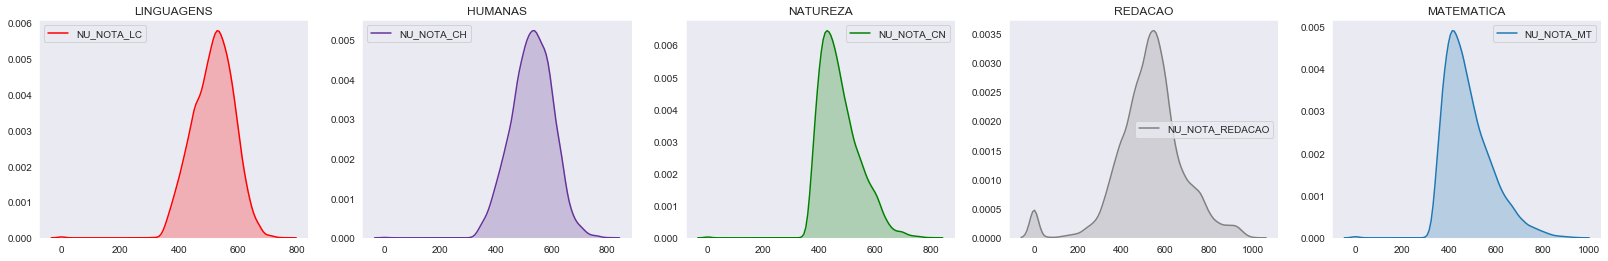

In [148]:
fig, axes = plt.subplots(1, 5, figsize=(28, 4))
sns.kdeplot(df_train['NU_NOTA_LC'], ax = axes[0], shade=True, color='r')
sns.kdeplot(df_train['NU_NOTA_CH'], ax = axes[1], shade=True, color='rebeccapurple')
sns.kdeplot(df_train['NU_NOTA_CN'], ax = axes[2], shade=True, color='g')
sns.kdeplot(df_train['NU_NOTA_REDACAO'], ax = axes[3], shade=True, color='grey')
sns.kdeplot(df_train['NU_NOTA_MT'], ax = axes[4], shade=True)

axes[0].set_title('LINGUAGENS')
axes[1].set_title('HUMANAS')
axes[2].set_title('NATUREZA')
axes[3].set_title('REDACAO')
axes[4].set_title('MATEMATICA')
plt.show()

This distribution make sense?

Yes. Here we can realize a negative skewness of Languagens and of Human Sciences, that are commonly recognized for having the easiest questions and a positive skewness of Nature Sciences and Math, that are commonly recognized for having the hardest questions. 

Furthermore, it is clear the effective presence of the Theory of Responses to the Index in the correction of objective questions, for which it is impossible for students to get a zero score, even if they miss all questions. In the essay, this does not occur for example, since their correction is done manually by professors.

Now, let's plot a heatmap to analyse the correlation between the features and our target (```NU_NOTA_MT```).

In [149]:
corr_mt = pd.DataFrame(df_train.corr()['NU_NOTA_MT'].sort_values(ascending=False))

In [150]:
corr_mt.head(15)

,NU_NOTA_MT
NU_NOTA_MT,1.000000
NU_NOTA_CN,0.584941
NU_NOTA_CH,0.529594
NU_NOTA_LC,0.494695
NU_NOTA_REDACAO,0.379376
TP_DEPENDENCIA_ADM_ESC,0.373233
NU_NOTA_COMP3,0.350307
NU_NOTA_COMP5,0.343337
NU_NOTA_COMP4,0.342282
NU_NOTA_COMP2,0.335638


```NU_NOTA_COMP1```, ```NU_NOTA_COMP2```, ```NU_NOTA_COMP3```, ```NU_NOTA_COMP4``` and ```NU_NOTA_COMP5``` variables have a relatively good correlation with our target but they tell us about the grades according to the skills assessed in the essay, which in turn is already described in the column ```NU_NOTA_REDACAO```. 

Thus, we will work with the five most correlated variablels: ```NU_NOTA_CN```, ```NU_NOTA_CH```, ```NU_NOTA_LC```, ```NU_NOTA_REDACAO``` and ```TP_DEPENDENCIA_ADM_ESC```. 


In [151]:
X = df_train[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_DEPENDENCIA_ADM_ESC']]
y = df_train[['NU_NOTA_MT']]

## Data Processing

Checking the percentage of missing values.

In [152]:
X.isnull().sum()/X.shape[0]

NU_NOTA_CN                0.246832
NU_NOTA_CH                0.246832
NU_NOTA_LC                0.261981
NU_NOTA_REDACAO           0.261981
TP_DEPENDENCIA_ADM_ESC    0.688128
dtype: float64

```TP_DEPENDENCIA_ADM_ESC``` has 68% of null values and because of it doesn't look like a interesting variable to have as a feature. Therefore, let's drop it. 

In [153]:
X.drop(columns='TP_DEPENDENCIA_ADM_ESC', inplace=True)

The missing values in the other features probably indicate that the student missed that test, so we are going to replace it with a value impossible to be acquired by someone who has taken the test - in this case, a negative grade.

We will also choose a value that is far from zero, since it is possible to have a score of zero in the essay and we do not want to generate a distortion of our model in these cases.

In [154]:
X['NU_NOTA_LC'].fillna(-1000, inplace=True)
X['NU_NOTA_CH'].fillna(-1000, inplace=True)
X['NU_NOTA_CN'].fillna(-1000, inplace=True)
X['NU_NOTA_REDACAO'].fillna(-1000, inplace=True)
y['NU_NOTA_MT'].fillna(-1000, inplace=True)

Now, let's remove the observations with all of the values as missing, because they don't give us any information.

To evaluate our model, we need to divide the dataset in train and test datasets:

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=777)

## Machine Learning Models

In this section, let's choose some models and try. At the end, we will keep with the more accurate one.

### Linear Regression

In [156]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [157]:
y_pred = reg.predict(X_test)

In [158]:
r2_score(y_test, y_pred)

0.9879143867654371

In [159]:
mean_squared_error(y_test, y_pred)

5284.884425769886

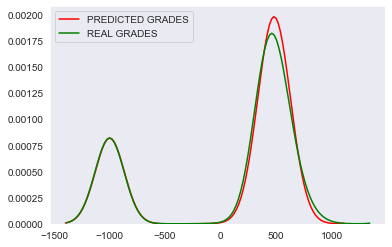

In [160]:
sns.distplot(y_pred, color='r', label='PREDICTED GRADES', hist=False)
sns.distplot(y_test, color='g', label='REAL GRADES', hist=False) 
plt.show()

## Lasso Regressor

In [161]:
reg = linear_model.TheilSenRegressor(random_state=777)
reg.fit(X_train, y_train)

TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
                  max_subpopulation=10000, n_jobs=None, n_subsamples=None,
                  random_state=777, tol=0.001, verbose=False)

In [162]:
y_pred = reg.predict(X_test)

In [163]:
r2_score(y_test, y_pred)

0.9372964079394607

In [164]:
mean_squared_error(y_test, y_pred)

27419.48055832833

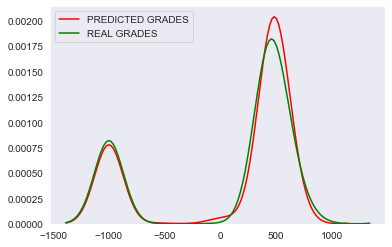

In [165]:
sns.distplot(y_pred, color='r', label='PREDICTED GRADES', hist=False)
sns.distplot(y_test, color='g', label='REAL GRADES', hist=False) 
plt.show()

## Random Forest


In [166]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=777)
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=777, verbose=0, warm_start=False)

In [167]:
y_pred = random_forest.predict(X_test)

In [168]:
 r2_score(y_test, y_pred)

0.9899921528093261

In [169]:
mean_squared_error(y_test, y_pred)

4376.303852105716

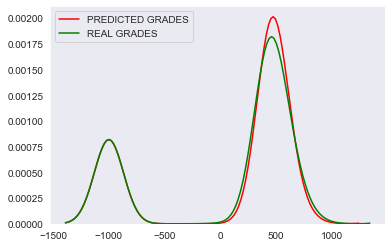

In [170]:
sns.distplot(y_pred, color='r', label='PREDICTED GRADES', hist=False)
sns.distplot(y_test, color='g', label='REAL GRADES', hist=False) 
plt.show()

## Generating the answer

In our tests, Random Forest had the smaller MSE and the biggest R2. So, as we have separate notes to use in submitting the challenge, we can retrain our model using all the observations this time.

Also, we will adapt our answer to the required conditions: we must save the answer in a file called answer.csv with two columns: ```NU_INSCRICAO``` and ```NU_NOTA_MT```.

In [171]:
# Selecting the features and filling missing values.
X_answer = df_test[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']].fillna(-1000)

In [172]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=777)
random_forest.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=777, verbose=0, warm_start=False)

In [173]:
Y_answer = random_forest.predict(X_answer)

As explained before, it is impossible to get negative marks in ENEM and this choice was made only for the purpose of training the model, now we can replace these values again with NaN.

In [174]:
Y_answer[Y_answer<0] = 0

In [175]:
df_test['NU_NOTA_MT']=np.around(Y_answer, 2)

In [176]:
df_test = df_test[['NU_INSCRICAO','NU_NOTA_MT']]

In [177]:
df_test

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,409.27
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,445.62
2,b38a03232f43b11c9d0788abaf060f7366053b6d,590.01
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.00
4,715494628a50142ce8cb17191cfe6d0f3cae0934,512.44
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,459.24
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,470.95
4573,655fa6306720ff16e825903b5422a46608a77545,671.54
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,464.99


Finally, we can convert the dataframe to csv and submit the challenge. 

In [178]:
df_test.to_csv('answer.csv', index=False)